# PS1-5. Locally weighted linear regression

### (a)

#### i. 
Recall the cost function

\begin{align*}
J(\theta) 
    & = \frac{1}{2} \sum_{i = 1}^{m} w^{(i)} ( \theta^T x^{(i)} - y^{(i)} )^2 \\
    & = (X \theta - y)^T W (X \theta - y)
\end{align*}

As $X \in \mathbb{R}^{m \times n}$, $y \in \mathbb{R}^{m}$ and there are only $m$ $w^{(i)}$ and there are no intersection of residuals
$$W = \frac{1}{2} \mathrm{diag} (w^{(i)}, \dots , w^{(m)})$$

#### ii. 
Recall the loss function $J(\theta) = \frac{1}{2} (X \theta - y)^T W (X \theta - y)$. To minimize $J(\theta)$, we have

\begin{align*}
\nabla_\theta J(\theta) 
    & = \nabla_\theta \left(\frac{1}{2}(X \theta - y)^T W (X \theta - y) \right) \\
    & = \frac{1}{2} \nabla_\theta (\theta^T X^T W X \theta - 2 y^T W X \theta + y^T W y) \\
    & = \frac{1}{2} \nabla_\theta \left( \theta^T (X^T W X) \theta 
            - 2 (X^T W^T y)^T \theta \right) \\
    & = \frac{1}{2} (2 X^T W X \theta - 2 X^T W^T y) \\
    & = X^T W X \theta - X^T W^T y \\
    & = X^T W X \theta - X^T W y \\
    & = 0
\end{align*}

By solving the equation, we obtain:
$$\theta = (X^T W X)^{-1} X^T W y$$

#### iii. 
We find the log-likelihood to be
\begin{align*}
\ell (\theta) 
& = \sum_{i = 1}^{m} \log \left( \frac{1}{\sqrt{2 \pi} \sigma^{(i)}} 
    \exp ( - \frac{(y^{(i)} - \theta^T x^{(i)})^2}{2 (\sigma^{(i)})^2} ) \right) \\
& = - \sum_{i = 1}^{m} \log \sqrt{2 \pi} \sigma^{(i)} 
    - \sum_{i = 1}^{m} \frac{(y^{(i)} - \theta^T x^{(i)})^2}{2 (\sigma^{(i)})^2} \\
\end{align*}

Thus, maximizing $\ell (\theta)$ is equivalent to minimizing

$$\frac{1}{2} \sum_{i = 1}^{m} \frac{1}{(\sigma^{(i)})^2} (\theta^T x^{(i)} - y^{(i)})^2$$

By setting $w^{(i)} = \frac{1}{ (\sigma^{(i)})^2}$, finding the maximum likelihood estimate of $\theta$ reduces to minimizing $J(\theta)$.

#### (b)

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import src.util as util

from src.linear_model import LinearModel

In [3]:
x_train, y_train = util.load_dataset('data/ds5_train.csv', add_intercept=True)
x_valid, y_valid = util.load_dataset('data/ds5_valid.csv', add_intercept=True)
x_test, y_test = util.load_dataset('data/ds5_test.csv', add_intercept=True)

Have a look at the whole training set:

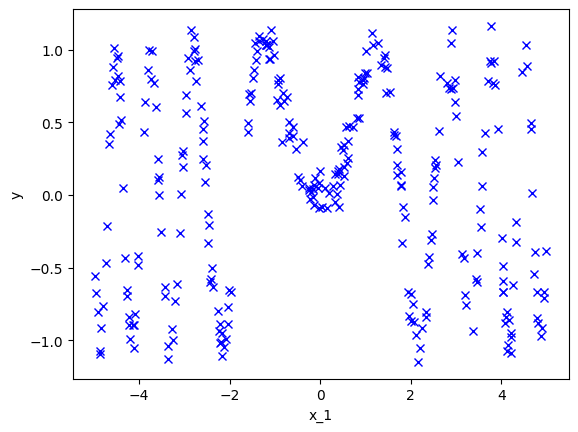

In [4]:
plt.xlabel('x_1')
plt.ylabel('y')
plt.plot(x_train[:, -1], y_train, 'bx', linewidth=2) # x_train[:,-2] as the intercept
plt.show()

Then we implement the weighted linear regression:

In [11]:
class LocallyWeightedLinearRegression(LinearModel):
    """Locally Weighted Regression (LWR).

    Example usage:
        > clf = LocallyWeightedLinearRegression(tau)
        
        > clf.fit(x_train, y_train)
        
        > clf.predict(x_eval)
    """

    def __init__(self, tau):
        super(LocallyWeightedLinearRegression, self).__init__()
        self.tau = tau
        self.x = None
        self.y = None

    def fit(self, x, y):
        """Fit LWR by saving the training set.
        """
        self.x = x
        self.y = y

    def predict(self, x):
        """Make predictions given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        m, n = x.shape
        
        # Calculate the deduction between two arrays: (300, 2) - (200, 1, 2)
        delta_x = self.x - np.reshape(x, (m, -1, n)) # broadcast: (200, 300, 2) 
        
        # Calculate the difference between the prediction and the traing point 
        norm_squ_x = np.linalg.norm(delta_x, ord=2, axis= 2)**2   # (200, 300)
        
        w_vector = np.exp(- norm_squ_x / (2 * self.tau**2)) # (200, 300)

        # Turn the weights into diagonal matrices.
        w = np.apply_along_axis(np.diag, axis=1, arr=w_vector) # (200, 300, 300)
        
        # Compute theta: \theta = (X^T w X)^-1 (X^T w Y) (300, 2)
        theta = np.linalg.inv(self.x.T @ w @ self.x) @ self.x.T @ w @ self.y 
        
        # Perform element-wise multiplications, and add up by rows.
        return np.sum(x * theta, axis=1) 

In [12]:
clf = LocallyWeightedLinearRegression(tau=0.5)
clf.fit(x_train, y_train)

In [15]:
def plot(x, y_label, y_pred, title):
    plt.figure()
    plt.plot(x[:, -1], y_label, 'bx', label='label')
    plt.plot(x[:, -1], y_pred, 'ro', label='prediction')
    plt.suptitle(title, fontsize=12)
    plt.legend(loc='upper left')

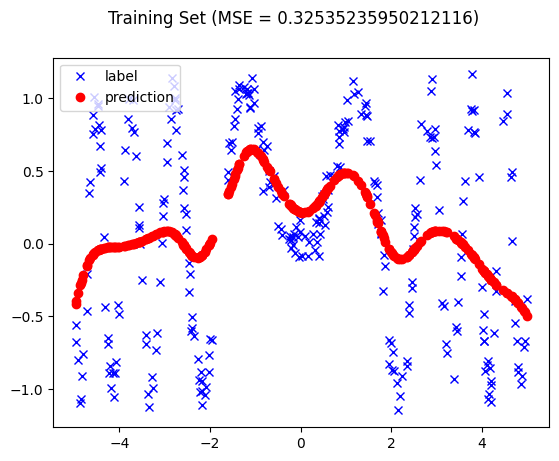

In [23]:
y_train_pred = clf.predict(x_train)
plot(x_train, y_train, y_train_pred, \
    f'Training Set (MSE = {np.mean((y_train_pred - y_train)**2)})')

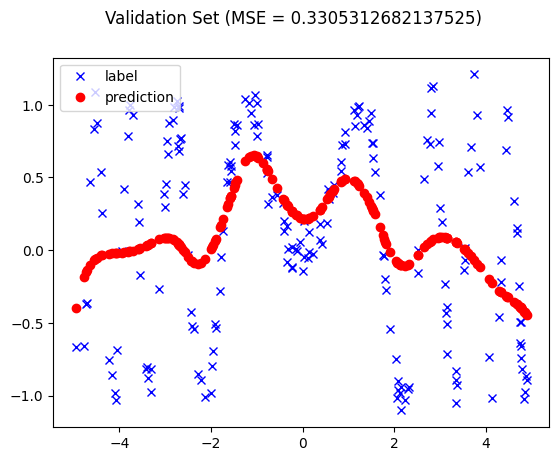

In [22]:
y_valid_pred = clf.predict(x_valid)
plot(x_valid, y_valid, y_valid_pred, \
    f'Validation Set (MSE = {np.mean((y_valid_pred - y_valid)**2)})')

From the figure, the model seem to be underfitting.

#### (c)

We tune several $\tau$ for the lowest MSE:

Tau = 0.05 achieves the lowest MSE on the validation set.


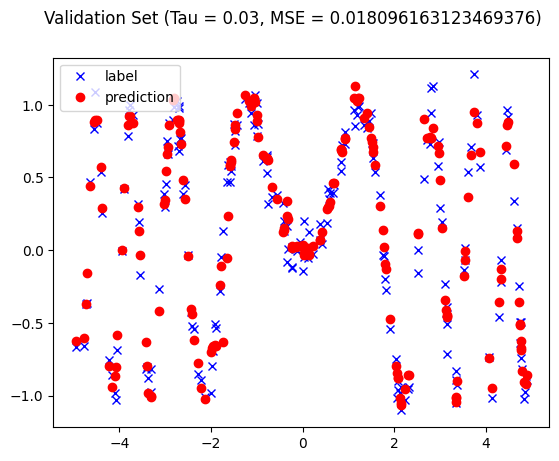

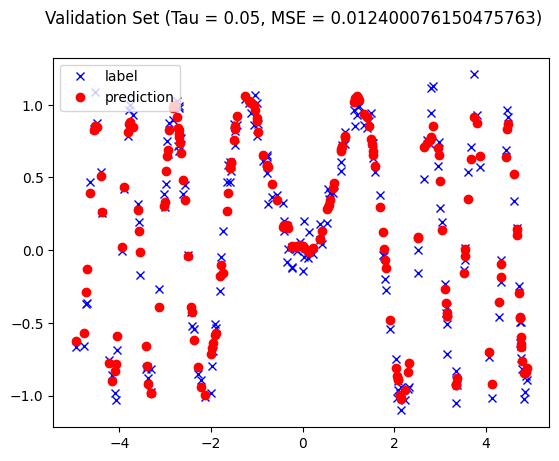

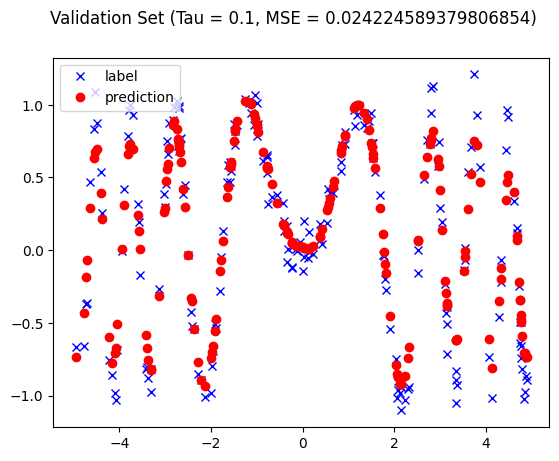

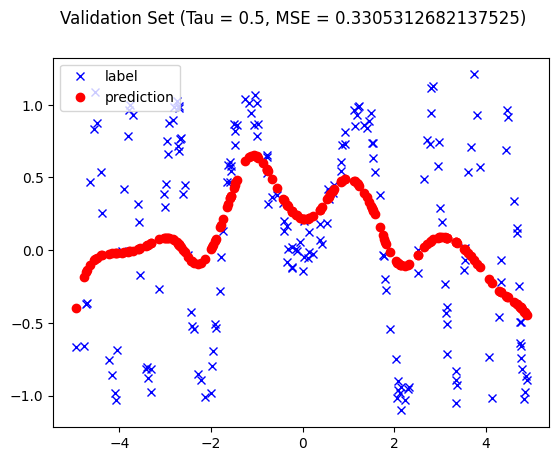

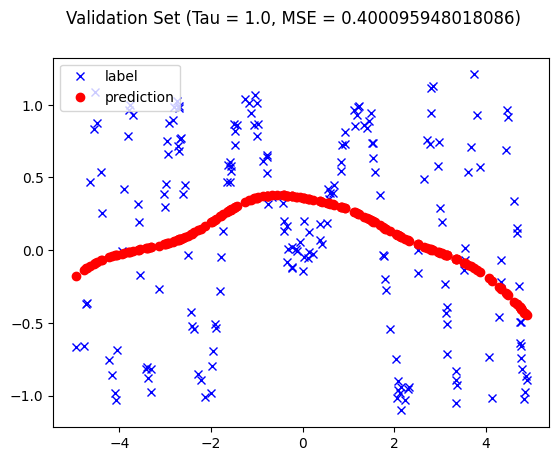

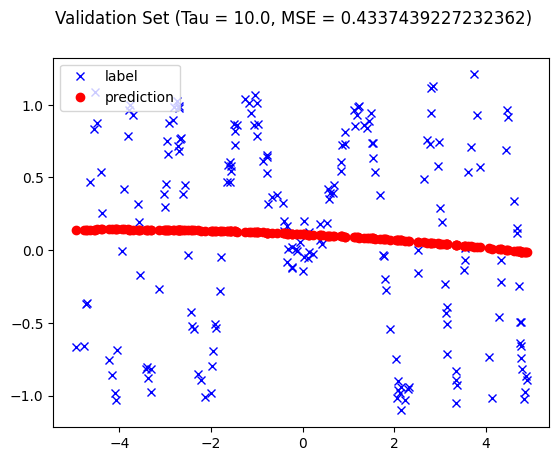

In [24]:
taus = [3e-2, 5e-2, 1e-1, 5e-1, 1e0, 1e1]

lowest_mse = math.inf
best_tau = taus[0]

for tau in taus:
    clf = LocallyWeightedLinearRegression(tau)
    clf.fit(x_train, y_train)
    y_valid_pred = clf.predict(x_valid)

    mse = np.mean((y_valid_pred - y_valid)**2)
    if mse < lowest_mse:
        lowest_mse = mse
        best_tau = tau

    plot(x_valid, y_valid, y_valid_pred, \
         f'Validation Set (Tau = {tau}, MSE = {mse})')

print(f'Tau = {best_tau} achieves the lowest MSE on the validation set.')

Use $\tau = 0.05$ to make predictions on test set:

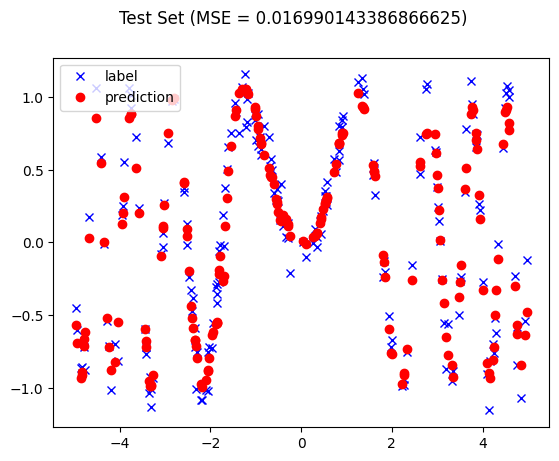

In [25]:
clf = LocallyWeightedLinearRegression(tau=0.05)
clf.fit(x_train, y_train)
y_test_pred = clf.predict(x_test)

plot(x_test, y_test, y_test_pred, \
     f'Test Set (MSE = {np.mean((y_test_pred - y_test)**2)})')